# Week 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import edhec_risk_kit as erk

In [14]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Portfolio diversification
Things about diversification:

1. diversification **is not** an effective way to decrease downside risk: in fact, conditional upon market downturns, correlation levels tend to increase and diversification benefits tend to disappear;
2. diversification is an effective way to increase the reward per unit of risk;
3. diversification is an effective way to decrease **idiosyncratic or specific** risk: in fact, it allows investors to reduce specific risk within their portfolios, which is how they can achieve a high reward per unit of risk.
4. diversification **is not** an effective way to decrease the **systemic risk**: basically, if the entire market collapses, it does not really matter how much your portfolio is diversified. 

**Market capitalization** of a stock (of a company) is the **total value of the stock**, 
that is, it is the number of shares outstanding of that stock multiplied by the share price.

Let us load the Industry following datasets

In [15]:
ind_rets   = erk.get_ind_returns()
ind_nfirms = erk.get_ind_nfirms()
ind_size   = erk.get_ind_size() 

In [17]:
ind_rets.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08-01,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09-01,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386


The dataframe **ind_rets** contains the returns (from 1926-2018) of $30$ portfolios including different industry sectors such as food, beer, smoke, etc. Such portofolios are constructed by using weights equal to the corresponding market capitalizations. 

For example, the columns **Food** contains the returns of a portfolio consisting of all the companies in the food sectors for each month from 1926 to 2019. The portfolio has been constructed by weighting each company according to its market capitalization.

Now, the number of firms composing each single sector are stored in **ind_nfirms**:

In [18]:
ind_nfirms.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


that is, in 1926-07, there were 43 (food) companies in the Food portfolio, 3 (beer) companies in the Beer portfolio, etc.

Finally, the datframe **ind_size** contains the **average size** of the companies composing the portfolio:

In [19]:
ind_size.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08-01,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09-01,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21


that is, the average size of the 43 Food companies in 1926-07 was 35.98, the average size of the 3 Beer companies was 7.12, ans so on (it does not matter the unit). 
By **average size** we mean the **average of the market capitalizations** of the 43 food companies, of the 3 Beer companies, etc.

#### Constructing the index
The first thing to do is to get the market capitalization of each industry sector. 
This is simply given by the number of firms times their average size:

In [37]:
ind_mkt_cap = ind_nfirms * ind_size
ind_mkt_cap.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,1547.14,21.36,955.52,184.87,24.04,178.16,220.32,178.64,979.03,80.34,...,1751.80,40.80,396.90,212.10,4951.34,2.38,1539.45,64.92,225.96,97.00
1926-08-01,1552.30,20.25,967.52,190.19,26.66,177.04,237.96,180.60,1056.21,80.60,...,1766.35,44.25,404.18,227.16,5031.26,1.80,1536.81,66.00,226.56,102.04
1926-09-01,1591.00,25.74,1024.48,191.10,29.34,169.44,231.48,187.11,1114.01,87.23,...,1804.80,45.15,417.27,220.92,5255.48,1.90,1521.63,65.64,236.04,108.84


Now, we want to get the **total market capitalization**, in order to get the fraction of the 
total market capitalization which is in each industry. 
This can be obtained by summing each single market capitalization of each sector every month, i.e., by summing the horizontally the **ind_mkt_cap**:

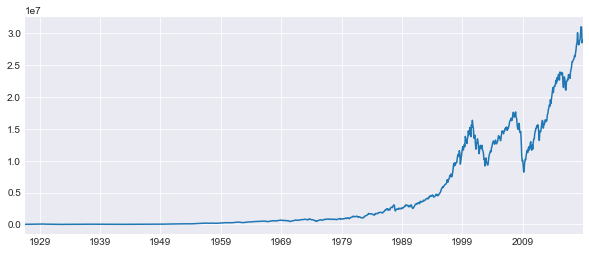

In [42]:
total_mkt_cap = ind_mkt_cap.sum(axis=1)
total_mkt_cap.plot(figsize=(10,4), grid=True)

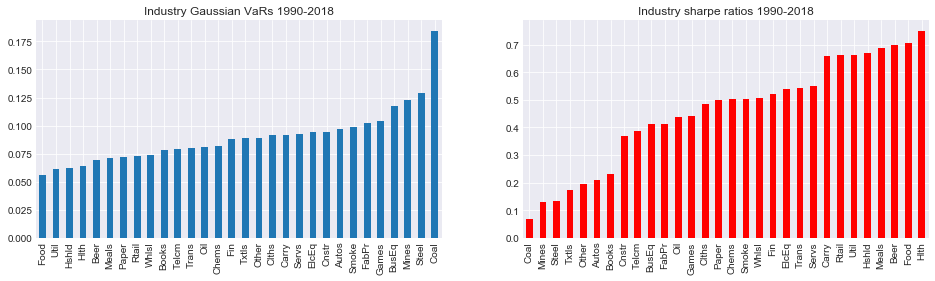

In [16]:
fig, ax = plt.subplots(figsize=(20,4), nrows=1, ncols=2)
erk.var_gaussian(ind_rets["1990":"2018"], cf=True).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[0], title="Industry Gaussian VaRs 1990-2018")
erk.sharpe_ratio(ind_rets["1990":"2018"], 0.0, 12).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[1], title="Industry sharpe ratios 1990-2018", color="r")
plt.show()